<a href="https://colab.research.google.com/github/Stephane-Masamba/Team_4_CPT_ML-Classification/blob/Mikael/Copy_of_Mikael_Daniels_Classification2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

Many companies are built around lessening their environmental impact and thus they offer products that are environmentally friendly and sustainable. With that, they would like to determine how people perceive climate change.




This notebook aims to create a Machine Learning model that is able to classify whether or not a person believes in climate change based on their novel tweet.


#Imports

###Import Libraries

In [1]:
!pip install spacy
!pip install NLTK

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from numpy import arange

import re
import spacy.cli
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import  KFold

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.utils import resample

#Machine Learning Models
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from google.colab import drive

In [3]:
spacy.cli.download('en_core_web_sm')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
nlp = spacy.load('en_core_web_sm')

#Read in the datasets

In [5]:
train = pd.read_csv('https://raw.githubusercontent.com/Stephane-Masamba/Team_4_CPT_ML-Classification/Mikael/train%20(1).csv')
print(train.head())

   sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954


In [6]:
test = pd.read_csv('https://raw.githubusercontent.com/Stephane-Masamba/Team_4_CPT_ML-Classification/Mikael/test%20(1).csv')
print(test.head())

                                             message  tweetid
0  Europe will now be looking to China to make su...   169760
1  Combine this with the polling of staffers re c...    35326
2  The scary, unimpeachable evidence that climate...   224985
3  @Karoli @morgfair @OsborneInk @dailykos \nPuti...   476263
4  RT @FakeWillMoore: 'Female orgasms cause globa...   872928


#Data Cleaning

Knowing that we are dealing with text data, we decided to first clean the data by making all tweets lower-case, removing punctuation marks and removing white spaces before doing anything else. Also, replacing all links with the word 'LINK' and all user handles with 'USER_REF'

In [7]:
def clean_text(df):
    i = 0
    for tweet in df['message']:
      tweet = tweet.lower()
      tweet = re.sub(r'http\S+', 'LINK', tweet)
      tweet = re.sub(r'@\S+', 'USER_REF', tweet)
      tweet = re.sub(r'[^\w\s]', '', tweet)
      tweet = tweet.lstrip()
      tweet = tweet.rstrip()
      tweet = tweet.replace('  ', ' ')
      df.loc[i, 'message'] = tweet
      i += 1

In [8]:
clean_text(train)
train

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,its not like we lack evidence of anthropogenic...,126103
2,2,rt USER_REF researchers say we have three year...,698562
3,1,todayinmaker wired 2016 was a pivotal year in ...,573736
4,1,rt USER_REF its 2016 and a racist sexist clima...,466954
...,...,...,...
15814,1,rt USER_REF they took down the material on glo...,22001
15815,2,rt USER_REF how climate change could be breaki...,17856
15816,0,notiven rt nytimesworld what does trump actual...,384248
15817,-1,rt USER_REF hey liberals the climate change cr...,819732


In [9]:
clean_text(test)

Here we add 'LINK' and 'USER_REF' to our list of stop words and remove all stop words from each tweet

In [10]:
def remove_stopwords(df):
    my_stop_words = stopwords.words('english')
    my_stop_words.append('LINK')
    my_stop_words.append('USER_REF')

    df_index = 0

    for tweet in df['message']:
      tweet = word_tokenize(tweet)
      tweet = [word for word in tweet if not word in my_stop_words]
      tweet = ' '.join(tweet)

      df.loc[df_index, 'message'] = tweet
      df_index += 1

    return df_index

In [11]:
remove_stopwords(train)

15819

In [12]:
train

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,rt researchers say three years act climate cha...,698562
3,1,todayinmaker wired 2016 pivotal year war clima...,573736
4,1,rt 2016 racist sexist climate change denying b...,466954
...,...,...,...
15814,1,rt took material global warming lgbt rights he...,22001
15815,2,rt climate change could breaking 200millionyea...,17856
15816,0,notiven rt nytimesworld trump actually believe...,384248
15817,-1,rt hey liberals climate change crap hoax ties ...,819732


In [13]:
remove_stopwords(test)
test

,message,tweetid
0,europe looking china make sure alone fighting ...,169760
1,combine polling staffers climate change womens...,35326
2,scary unimpeachable evidence climate change al...,224985
3,putin got jill trump doesnt believe climate ch...,476263
4,rt female orgasms cause global warming sarcast...,872928
...,...,...
10541,rt brb writing poem climate change climatechan...,895714
10542,2016 year climate change came home hottest yea...,875167
10543,rt pacific countries positive fiji leading glo...,78329
10544,rt youre hot must cause global warming aldubla...,867455


###Find all named entities for each tweet

In [14]:
def entities(df):
    df_index = 0

    for tweet in df['message']:
      tweet = nlp(tweet)

      for entity in tweet.ents:
        df.loc[df_index, 'message'] = df.loc[df_index, 'message'].replace(str(entity.text), str(entity.label_))

      df_index += 1

In [15]:
entities(train)

In [16]:
train

,sentiment,message,tweetid
0,1,ORG chief doesnt think carbon dioxide main cau...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,rt researchers say DATE act climate change late,698562
3,1,todayinmaker wired DATE pivotal year war clima...,573736
4,1,rt DATE racist sexist climate change denying b...,466954
...,...,...,...
15814,1,rt took material global warming lgbt rights he...,22001
15815,2,rt climate change could breaking CARDINAL rela...,17856
15816,0,PERSON rt nytimesworld trump actually believe ...,384248
15817,-1,rt hey liberals climate change crap hoax ties ...,819732


In [17]:
entities(test)

###Lemmatize every word in each tweet

In [18]:
def lem_text(df):
    df_index = 0

    for tweet in df['message']:
      tweet = nlp(tweet)
      
      for token in tweet:
        df.loc[df_index, 'message'] = df.loc[df_index, 'message'].replace(str(token.text), str(token.lemma_))

      df_index += 1

In [19]:
lem_text(train)

In [20]:
train

,sentiment,message,tweetid
0,1,ORG chief donot think carbon dioxide main caus...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,rt researcher say DATE act climate change late,698562
3,1,todayinmaker wire DATE pivotal year war climat...,573736
4,1,rt DATE racist sexist climate change deny bigo...,466954
...,...,...,...
15814,1,rt take material global warming lgbt right hea...,22001
15815,2,rt climate change could break CARDINAL relatio...,17856
15816,0,person rt nytimesworld trump actually believe ...,384248
15817,-1,rt hey liberal climate change crap hoax ties a...,819732


In [21]:
lem_text(test)

In [22]:
test

,message,tweetid
0,LOC look GPE make sure alone fight climate change,169760
1,combine polling staffer climate change women r...,35326
2,scary unimpeachable evidence climate change al...,224985
3,person get person donot believe climate change...,476263
4,rt female orgasm cause global warm sarcastic NORP,872928
...,...,...
10541,rt brb write poem climate change climatechange...,895714
10542,date climate change come home hot date record ...,875167
10543,rt pacific country positive GPE lead global cl...,78329
10544,rt -PRON-be hot must cause global warming aldu...,867455


#Exploratory Data Analysis

Now it is time to analyse the data and how it is structured.

###Missing values

In [ ]:
train.isnull().sum()


sentiment    0
message      0
tweetid      0
dtype: int64

In [ ]:
test.isnull().sum()

message    0
tweetid    0
dtype: int64

There are no missing values in both the train and test datasets

###Sentiment Classes

In [23]:
train.sentiment.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

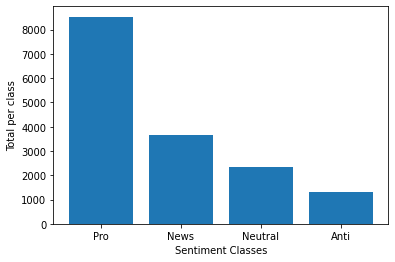

In [27]:
counts = train["sentiment"].value_counts()
plt.bar(range(len(counts)), counts)
plt.xticks([0, 1, 2, 3], ['Pro', 'News', 'Neutral', 'Anti'])

plt.ylabel("Total per class")
plt.xlabel("Sentiment Classes")
plt.show()

There classes are imbalanced and this might require some resampling techniques in order to improve the accuracyy of our model

###Any other data analysis/visual please

#Define our feature and target variable to use when modelling

In [ ]:
X = train['message']
X

0        ORG chief donot think carbon dioxide main caus...
1          like lack evidence anthropogenic global warming
2           rt researcher say DATE act climate change late
3        todayinmaker wire DATE pivotal year war climat...
4        rt DATE racist sexist climate change deny bigo...
                               ...                        
15814    rt take material global warming lgbt right hea...
15815    rt climate change could break CARDINAL relatio...
15816    person rt nytimesworld trump actually believe ...
15817    rt hey liberal climate change crap hoax ties a...
15818       rt climate change equation CARDINAL screenshot
Name: message, Length: 15819, dtype: object

In [ ]:
y = train['sentiment']
y

0        1
1        1
2        2
3        1
4        1
        ..
15814    1
15815    2
15816    0
15817   -1
15818    0
Name: sentiment, Length: 15819, dtype: int64

###Convert features to machine language

In [ ]:
tf_vect = TfidfVectorizer(ngram_range=(1, 2))
X = tf_vect.fit_transform(X)

###Splitting the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
#X_test = test['message']

In [ ]:
#X_test = tf_vect.transform(X_test)

#Modelling

##Modelling with maximum data cleaning

The function below takes in a model and returns the average accuracy score

In [ ]:
def accuracy(model):
    features = train['message']
    target = train['sentiment']

    train_scores = []
    test_scores = []

    tf_vect = TfidfVectorizer(ngram_range=(1, 2))

    folds = KFold(n_splits=5, shuffle=True)

    for train_index, test_index in folds.split(features):
        x_train, x_test = features.iloc[train_index], features.iloc[test_index]    
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        x_train = tf_vect.fit_transform(x_train)
        x_test = tf_vect.transform(x_test)
     
        model.fit(x_train, y_train)
        train_predictions = model.predict(x_train)
        test_predictions = model.predict(x_test)

        train_score = accuracy_score(y_train, train_predictions)
        train_scores.append(train_score)

        test_score = accuracy_score(y_test, test_predictions)
        test_scores.append(test_score)

    avg_train_accuracy = np.mean(train_scores)
    avg_test_accuracy = np.mean(test_scores)

    return [avg_train_accuracy, avg_test_accuracy]


###Support Vector Machines(SVM)

Support-Vector Machines algorithm goes like blah blah blah blah

In [ ]:
sv = SVC()

sv_accuracy = accuracy(sv)
sv_accuracy

[0.9659428410091604, 0.7152161148999594]

###Bernoulli

In [ ]:
bernoulli = BernoulliNB()

bernoulli_accuracy = accuracy(bernoulli)
bernoulli_accuracy

[0.7412604513139472, 0.629433502016241]

In [ ]:
mnb = MultinomialNB()

mnb_accuracy = accuracy(mnb)
mnb_accuracy

[0.6930431811154828, 0.6234274059297351]

In [ ]:
sgd = SGDClassifier()

sgd_accuracy = accuracy(sgd)
sgd_accuracy

[0.9368638940350775, 0.721790571530093]

###Random Forest

In [ ]:
rand_forest = RandomForestClassifier()

rand_forest_accuracy = accuracy(rand_forest)
rand_forest_accuracy

[0.9980087296786596, 0.6889186281167402]

###K-Nearest Neighbors (KNN)

In [ ]:
knn = KNeighborsClassifier()

knn_accuracy = accuracy(knn)
knn_accuracy

[0.7285700149998426, 0.6121748264242088]

In [ ]:
grad_booster = GradientBoostingClassifier()

grad_booster_accuracy = accuracy(grad_booster)
grad_booster_accuracy

[0.7057335937035625, 0.6633785557007321]

In [ ]:
extra_trees = ExtraTreesClassifier()

extra_trees_accuracy = accuracy(extra_trees)
extra_trees_accuracy

[0.998103547615135, 0.7068075364128457]

In [ ]:
bagging = BaggingClassifier()

bagging_accuracy = accuracy(bagging)
bagging_accuracy

[0.9774954046436075, 0.6357538551192218]

In [ ]:
dec_tree = DecisionTreeClassifier()

dec_tree_accuracy = accuracy(dec_tree)
dec_tree_accuracy

[0.9981035463663968, 0.5898608196142743]

In [ ]:
linear_sv = LinearSVC()

linear_sv_accuracy = accuracy(linear_sv)
linear_sv_accuracy

[0.9935204550801415, 0.728048372997998]

##Plot all models and respective accuracy scores

Below is a graph of all models which allows for simplified comparison


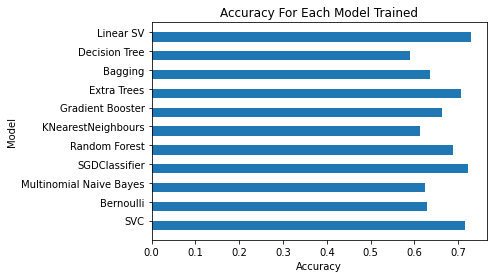

In [ ]:
models = ['SVC', 'Bernoulli', 'Multinomial Naive Bayes', 'SGDClassifier', 'Random Forest', 'KNearestNeighbours', 'Gradient Booster', 'Extra Trees', 'Bagging', 'Decision Tree', 'Linear SV']
bar_widths = [sv_accuracy[1], bernoulli_accuracy[1], mnb_accuracy[1], sgd_accuracy[1], rand_forest_accuracy[1], knn_accuracy[1], grad_booster_accuracy[1], extra_trees_accuracy[1], bagging_accuracy[1], dec_tree_accuracy[1], linear_sv_accuracy[1]]
bar_positions = arange(11) + 0.75
tick_positions = range(1,12)

fig, ax = plt.subplots()
ax.barh(bar_positions, bar_widths, 0.5)
ax.set_yticks(tick_positions)
ax.set_yticklabels(models)

ax.set_ylabel('Model')
ax.set_xlabel('Accuracy')
ax.set_title('Accuracy For Each Model Trained')

plt.show()

###Fit best model and use the metrics module

In [ ]:
linear_sv.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
#confusion matrix and classification_report
y_pred = linear_sv.predict(X_test)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test,y_pred))

print('Accuracy score: ' + str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test,y_pred))

[[  80   27  128   14]
 [   7  150  266   50]
 [   9   53 1503  136]
 [   2   11  184  544]]
Accuracy score: 0.7196586599241467
              precision    recall  f1-score   support

          -1       0.82      0.32      0.46       249
           0       0.62      0.32      0.42       473
           1       0.72      0.88      0.79      1701
           2       0.73      0.73      0.73       741

    accuracy                           0.72      3164
   macro avg       0.72      0.56      0.60      3164
weighted avg       0.72      0.72      0.70      3164



In [ ]:
sgd.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
y_predict = sgd.predict(X_test)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test,y_predict))

print('Accuracy score: ' + str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test,y_predict))



[[  71   17  142   19]
 [   4  121  298   50]
 [   6   31 1536  128]
 [   2    8  205  526]]
Accuracy score: 0.7196586599241467
              precision    recall  f1-score   support

          -1       0.86      0.29      0.43       249
           0       0.68      0.26      0.37       473
           1       0.70      0.90      0.79      1701
           2       0.73      0.71      0.72       741

    accuracy                           0.71      3164
   macro avg       0.74      0.54      0.58      3164
weighted avg       0.72      0.71      0.68      3164



##Modelling with resampled data


To try and improve the accuracy of the above modelling, let's introduced data resampling as we have already seen that the classes are imbalanced. 

###Downsampling

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/Stephane-Masamba/Team_4_CPT_ML-Classification/Mikael/train%20(1).csv')
print(train.head())

   sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954


In [ ]:
test = pd.read_csv('https://raw.githubusercontent.com/Stephane-Masamba/Team_4_CPT_ML-Classification/Mikael/test%20(1).csv')
print(test.head())

                                             message  tweetid
0  Europe will now be looking to China to make su...   169760
1  Combine this with the polling of staffers re c...    35326
2  The scary, unimpeachable evidence that climate...   224985
3  @Karoli @morgfair @OsborneInk @dailykos \nPuti...   476263
4  RT @FakeWillMoore: 'Female orgasms cause globa...   872928


In [ ]:
X = train['message']
y = train['sentiment']


X_train1,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
train_majority = train[train.sentiment== 1]
train_01 = train[train.sentiment<= 0]
train_2 = train[train.sentiment== 2]
#train_minority = train[train.sentiment== -1]
train_minority = pd.concat([train_01, train_2])

In [ ]:
# Downsample majority class
train_majority_downsampled = resample(train_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=1296,     # to match minority class
                                 random_state=123) # reproducible results



# Combine minority class with downsampled majority class
train_downsampled = pd.concat([train_majority_downsampled, train_minority])

In [ ]:
train_downsampled

,sentiment,message,tweetid
11177,1,RT @MorrisseyHelena: My view on clean/green/ne...,967739
13782,1,RT @betterthemask: Before the Flood's free to ...,350132
12981,1,"RT @kelkulus: Irony: Florida, a state in dange...",619610
10340,1,someone who doesnt believe in climate change: ...,258258
868,1,RT @IzhaarEMuzamat: KP is fighting climate cha...,454755
...,...,...,...
15802,2,Michael Bloomberg to world leaders: ignore Tru...,585908
15803,2,"Suicides of nearly 60,000 Indian farmers linke...",296403
15805,2,RT @GrindTV: New head of EPA says climate chan...,830383
15809,2,The quest to capture and store carbon — and sl...,705048


In [ ]:
train_downsampled['sentiment'].value_counts()

 2    3640
 0    2353
-1    1296
 1    1296
Name: sentiment, dtype: int64

In [ ]:
clean_text(train)

In [ ]:
remove_stopwords(train)

In [ ]:
entities(train)

In [ ]:
lem_text(train)

In [ ]:
X_down = train['message']
X_down

0        ORG chief donot think carbon dioxide main caus...
1          like lack evidence anthropogenic global warming
2           rt researcher say DATE act climate change late
3        todayinmaker wire DATE pivotal year war climat...
4        rt DATE racist sexist climate change deny bigo...
                               ...                        
15814    rt take material global warming lgbt right hea...
15815    rt climate change could break CARDINAL relatio...
15816    person rt nytimesworld trump actually believe ...
15817    rt hey liberal climate change crap hoax ties a...
15818       rt climate change equation CARDINAL screenshot
Name: message, Length: 15819, dtype: object

In [ ]:

y_down = train['sentiment']
y_down

0        1
1        1
2        2
3        1
4        1
        ..
15814    1
15815    2
15816    0
15817   -1
15818    0
Name: sentiment, Length: 15819, dtype: int64

In [ ]:
X_down = tf_vect.fit_transform(X_down)
X_down

<15819x80252 sparse matrix of type '<class 'numpy.float64'>'
	with 309900 stored elements in Compressed Sparse Row format>

In [ ]:
#X_test = test['message']
#X_test = tf_vect.transform(X_test)


#split the data

X_train1,X_test1,y_train1,y_test1 = train_test_split(X_down,y_down,test_size=0.2,random_state=0)

In [ ]:
X_train

<12655x80252 sparse matrix of type '<class 'numpy.float64'>'
	with 248240 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.svm import LinearSVC
lsvm = LinearSVC()
lsvm.fit(X_train1, y_train1)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
#confusion matrix and classification_report
y_pred = lsvm.predict(X_test1)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


print(confusion_matrix(y_test1,y_pred))

print('Accuracy score: ' + str(accuracy_score(y_test1, y_pred)))
print(classification_report(y_test1,y_pred))

[[  80   27  128   14]
 [   7  150  266   50]
 [   9   53 1503  136]
 [   2   11  184  544]]
Accuracy score: 0.7196586599241467
              precision    recall  f1-score   support

          -1       0.82      0.32      0.46       249
           0       0.62      0.32      0.42       473
           1       0.72      0.88      0.79      1701
           2       0.73      0.73      0.73       741

    accuracy                           0.72      3164
   macro avg       0.72      0.56      0.60      3164
weighted avg       0.72      0.72      0.70      3164



###SMOTE 

In [ ]:
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


##Modelling with minimal data cleaning

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/Stephane-Masamba/Team_4_CPT_ML-Classification/Mikael/train%20(1).csv')
print(train.head())

   sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954


In [ ]:
test = pd.read_csv('https://raw.githubusercontent.com/Stephane-Masamba/Team_4_CPT_ML-Classification/Mikael/test%20(1).csv')
print(test.head())


                                             message  tweetid
0  Europe will now be looking to China to make su...   169760
1  Combine this with the polling of staffers re c...    35326
2  The scary, unimpeachable evidence that climate...   224985
3  @Karoli @morgfair @OsborneInk @dailykos \nPuti...   476263
4  RT @FakeWillMoore: 'Female orgasms cause globa...   872928


In [ ]:
sample = pd.read_csv('https://raw.githubusercontent.com/Stephane-Masamba/Team_4_CPT_ML-Classification/Mikael/sample_submission.csv')
print(sample.head())


   tweetid  sentiment
0   169760          1
1    35326          1
2   224985          1
3   476263          1
4   872928          1


###Data Cleaning

Below we clean the tweets made by individuals in order to allow for readability by our machines.Examples of how we clean the data is by removing punctuations,converting all leters to lower case,removing numbers and so on.

In [ ]:
clean_text(train)

In [ ]:
train

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,its not like we lack evidence of anthropogenic...,126103
2,2,rt USER_REF researchers say we have three year...,698562
3,1,todayinmaker wired 2016 was a pivotal year in ...,573736
4,1,rt USER_REF its 2016 and a racist sexist clima...,466954
...,...,...,...
15814,1,rt USER_REF they took down the material on glo...,22001
15815,2,rt USER_REF how climate change could be breaki...,17856
15816,0,notiven rt nytimesworld what does trump actual...,384248
15817,-1,rt USER_REF hey liberals the climate change cr...,819732


In [ ]:
clean_text(test)

In [ ]:
test

,message,tweetid
0,europe will now be looking to china to make su...,169760
1,combine this with the polling of staffers re c...,35326
2,the scary unimpeachable evidence that climate ...,224985
3,USER_REF USER_REF USER_REF USER_REF \nputin go...,476263
4,rt USER_REF female orgasms cause global warmin...,872928
...,...,...
10541,rt USER_REF brb writing a poem about climate c...,895714
10542,2016 the year climate change came home during ...,875167
10543,rt USER_REF pacific countries positive about f...,78329
10544,rt USER_REF youre so hot you must be the cause...,867455


In [ ]:
X_train = train['message']
X_train


0        polyscimajor epa chief doesnt think carbon dio...
1        its not like we lack evidence of anthropogenic...
2        rt USER_REF researchers say we have three year...
3        todayinmaker wired 2016 was a pivotal year in ...
4        rt USER_REF its 2016 and a racist sexist clima...
                               ...                        
15814    rt USER_REF they took down the material on glo...
15815    rt USER_REF how climate change could be breaki...
15816    notiven rt nytimesworld what does trump actual...
15817    rt USER_REF hey liberals the climate change cr...
15818    rt USER_REF USER_REF climate change equation i...
Name: message, Length: 15819, dtype: object

In [ ]:
y_train = train['sentiment']
y_train


0        1
1        1
2        2
3        1
4        1
        ..
15814    1
15815    2
15816    0
15817   -1
15818    0
Name: sentiment, Length: 15819, dtype: int64

###Convert to machine language

In [ ]:
X_train = tf_vect.fit_transform(X_train)


In [ ]:
X_test = test['message']


In [ ]:
X_test = tf_vect.transform(X_test)


##Support Vector Machine

In [ ]:
sv = SVC()

sv_accuracy = accuracy(sv)
sv_accuracy


[0.9759940517606959, 0.72905991087691]

###Stochastic Gradient Descent

In [ ]:
sgd = SGDClassifier()

sgd_accuracy = accuracy(sgd)
sgd_accuracy



[0.9484480819631763, 0.7432834332494116]

In [ ]:
linear_sv = LinearSVC()

linear_sv_accuracy = accuracy(linear_sv)
linear_sv_accuracy


[0.9957961941957653, 0.7527653218531432]

In [ ]:
linear_svc = LinearSVC()


In [ ]:
linear_sv.fit(X_train, y_train)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
predictions = linear_sv.predict(X_test)


In [ ]:
test['sentiment'] = predictions
test


,message,tweetid,sentiment
0,europe will now be looking to china to make su...,169760,1
1,combine this with the polling of staffers re c...,35326,1
2,the scary unimpeachable evidence that climate ...,224985,1
3,USER_REF USER_REF USER_REF USER_REF \nputin go...,476263,1
4,rt USER_REF female orgasms cause global warmin...,872928,0
...,...,...,...
10541,rt USER_REF brb writing a poem about climate c...,895714,1
10542,2016 the year climate change came home during ...,875167,1
10543,rt USER_REF pacific countries positive about f...,78329,2
10544,rt USER_REF youre so hot you must be the cause...,867455,0


In [ ]:
submission = test[['tweetid', 'sentiment']]
submission


,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0
...,...,...
10541,895714,1
10542,875167,1
10543,78329,2
10544,867455,0


#Model Analysis

#Conclusion